In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:

df_lagged = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\df_lagged.csv")
display(df_lagged.head(3))

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter,Totaal_verkochte_wegvoertuigen
0,2007-07-01,0,1,0,22,14.0,22.0,9.0,6.2,1.451,...,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3,124
1,2007-08-01,0,1,0,22,12.0,17.0,9.0,5.6,1.415,...,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3,96
2,2007-09-01,0,1,0,22,10.0,12.0,9.0,5.0,1.422,...,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3,120


# Baseline/default  

## Alleen Lag

### Linear regression


   Validation MAE  Validation RMSE  Validation R²  Validation MAPE
0      150.002498       174.990583       0.040455        20.675526


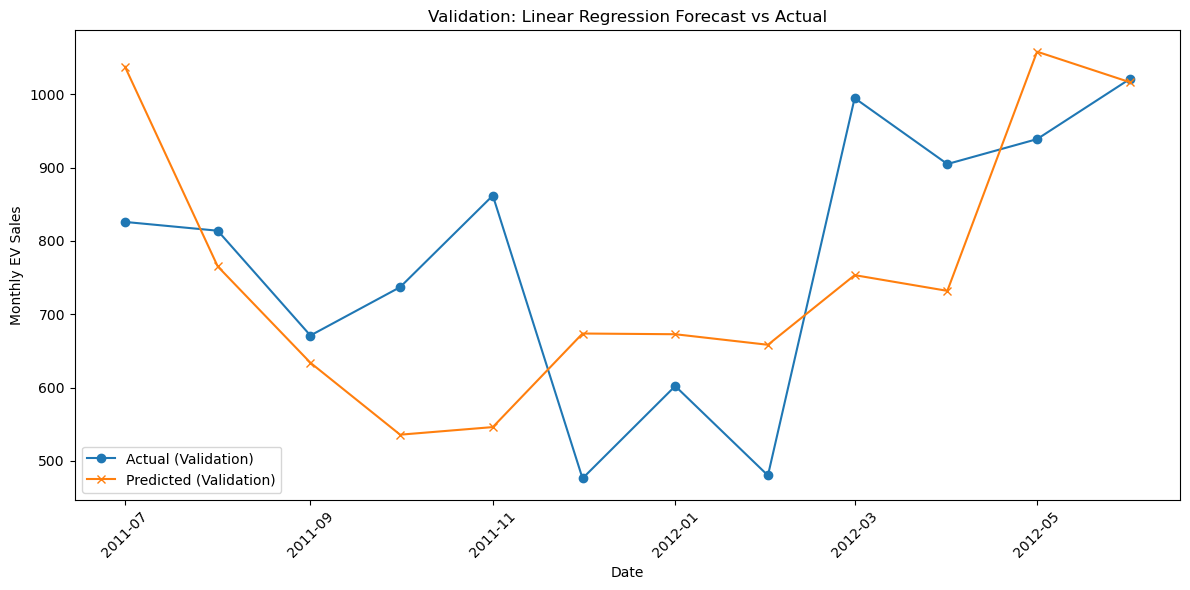

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features
lagged_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lagged_features

# Configuration
forecast_horizon = 3
initial_train_size = 48
validation_size = 12
step_size = 3
target_col = 'Totaal_verkochte_wegvoertuigen'

#
df = df_lagged
df['Periode'] = pd.to_datetime(df['Periode'])
X_all = df[lagged_features].values
y_all = df[target_col].values

# Define split points
train_end = initial_train_size
val_end = train_end + validation_size
test_start = val_end

# Split data
X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test = X_all[val_end:], y_all[val_end:]

# Fit on train, validate on validation set
model = LinearRegression()
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)

# Final fit on train+val for test prediction (walk-forward)
X_train_val, y_train_val = X_all[:val_end], y_all[:val_end]

predictions = []
actuals = []

for i in range(test_start, len(df) - forecast_horizon + 1, step_size):
    X_tv = X_all[:i]
    y_tv = y_all[:i]
    X_te = X_all[i:i + forecast_horizon]
    y_te = y_all[i:i + forecast_horizon]

    model = LinearRegression()
    model.fit(X_tv, y_tv)
    y_pred = model.predict(X_te)

    predictions.extend(y_pred)
    actuals.extend(y_te)

# Evaluation
predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

metrics = {
    'Validation MAE': mean_absolute_error(y_val, y_val_pred),
    'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'Validation R²': r2_score(y_val, y_val_pred),
    'Validation MAPE': np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100,
   }
results_df = pd.DataFrame([metrics])
print(results_df)

# Plot validation predictions vs actuals using validation periods
val_periods = df['Periode'].iloc[train_end:val_end]

plt.figure(figsize=(12, 6))
plt.plot(val_periods, y_val, label='Actual (Validation)', marker='o')
plt.plot(val_periods, y_val_pred, label='Predicted (Validation)', marker='x')
plt.title('Validation: Linear Regression Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


   Validation MAE  Validation RMSE  Validation R²  Validation MAPE
0      159.251266       195.051325      -0.192158        25.237572


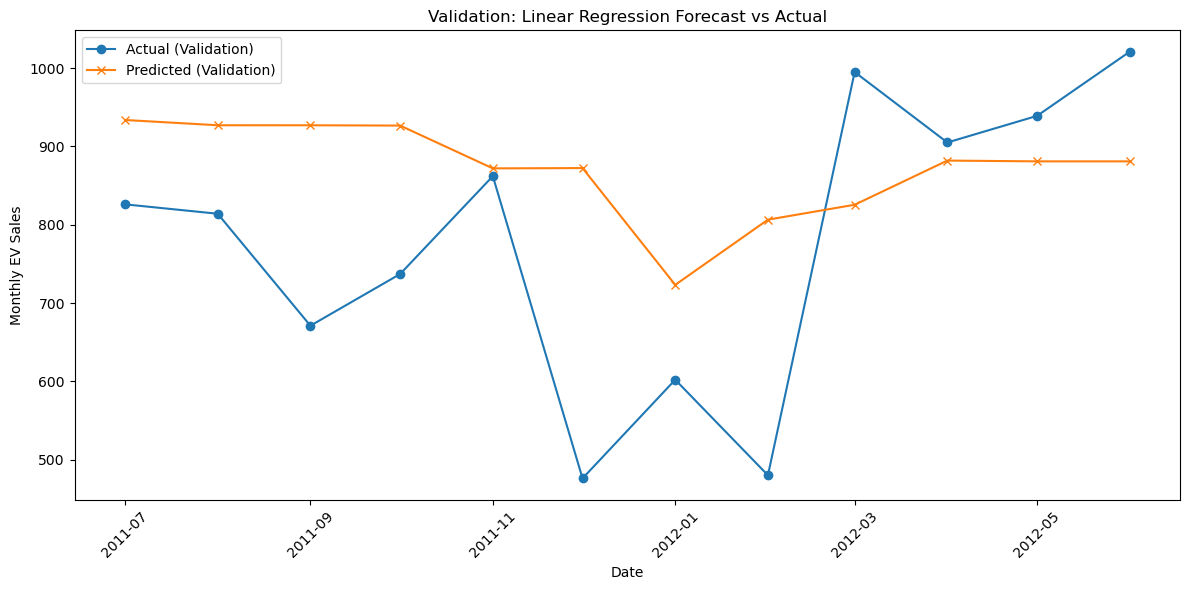

In [19]:
for i in range(test_start, len(df) - forecast_horizon + 1, step_size):
    X_tv = X_all[:i]
    y_tv = y_all[:i]
    X_te = X_all[i:i + forecast_horizon]
    y_te = y_all[i:i + forecast_horizon]

    model = LinearRegression()
    model.fit(X_tv, y_tv)
    y_pred = model.predict(X_te)

    predictions.extend(y_pred)
    actuals.extend(y_te)

# Evaluation
predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

metrics = {
    'Validation MAE': mean_absolute_error(y_val, y_val_pred),
    'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'Validation R²': r2_score(y_val, y_val_pred),
    'Validation MAPE': np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100,
   }
results_df = pd.DataFrame([metrics])
print(results_df)

# Plot validation predictions vs actuals using validation periods
val_periods = df['Periode'].iloc[train_end:val_end]

plt.figure(figsize=(12, 6))
plt.plot(val_periods, y_val, label='Actual (Validation)', marker='o')
plt.plot(val_periods, y_val_pred, label='Predicted (Validation)', marker='x')
plt.title('Validation: Linear Regression Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Monthly EV Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### ARIMAX

In [25]:
# Initialize as lists to use .extend()
predictions = []
actuals = []

for i in range(test_start, len(df) - forecast_horizon + 1, step_size):
    X_tv = X_all[:i]
    y_tv = y_all[:i]
    X_te = X_all[i:i + forecast_horizon]
    y_te = y_all[i:i + forecast_horizon]

    model = SARIMAX(y_tv, exog=X_tv, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    # Predict for the next forecast_horizon steps
    y_pred = results.predict(start=len(y_tv), end=len(y_tv) + forecast_horizon - 1, exog=X_te)

    predictions.extend(y_pred)
    actuals.extend(y_te)

# Evaluation
predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

metrics = {
    'Validation MAE': mean_absolute_error(y_val, y_val_pred),
    'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'Validation R²': r2_score(y_val, y_val_pred),
    'Validation MAPE': np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100,
   }
results_df = pd.DataFrame([metrics])
print(results_df)


   Validation MAE  Validation RMSE  Validation R²  Validation MAPE
0      159.251266       195.051325      -0.192158        25.237572


### xGBOOST

In [23]:
# Initialize as lists to use .extend()
predictions = []
actuals = []

for i in range(test_start, len(df) - forecast_horizon + 1, step_size):
    X_tv = X_all[:i]
    y_tv = y_all[:i]
    X_te = X_all[i:i + forecast_horizon]
    y_te = y_all[i:i + forecast_horizon]

    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_tv, y_tv)
    y_pred = model.predict(X_te)

    predictions.extend(y_pred)
    actuals.extend(y_te)

# Evaluation
predictions = np.array(predictions)
actuals = np.array(actuals)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

metrics = {
    'Validation MAE': mean_absolute_error(y_val, y_val_pred),
    'Validation RMSE': np.sqrt(mean_squared_error(y_val, y_val_pred)),
    'Validation R²': r2_score(y_val, y_val_pred),
    'Validation MAPE': np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100,
   }
results_df = pd.DataFrame([metrics])
print(results_df)


   Validation MAE  Validation RMSE  Validation R²  Validation MAPE
0      159.251266       195.051325      -0.192158        25.237572
